In [760]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Flatten
from tensorflow.keras.layers import GRU, Bidirectional, LSTM, Dense, Dropout, TimeDistributed, MultiHeadAttention, LayerNormalization, Conv1D, GlobalAveragePooling1D
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Read data

In [603]:
df_fpt = pd.read_csv("FPT.csv", index_col='Date/Time')
df_fpt.index = pd.to_datetime(df_fpt.index, format='%m/%d/%Y %H:%M')

In [604]:
df_msn = pd.read_csv("MSN.csv", index_col='Date/Time')
df_msn.index = pd.to_datetime(df_msn.index, format='%m/%d/%Y %H:%M')

In [605]:
df_pnj = pd.read_csv("PNJ.csv", index_col='Date/Time')
df_pnj.index = pd.to_datetime(df_pnj.index, format='%m/%d/%Y %H:%M')

In [606]:
df_vic = pd.read_csv("VIC.csv", index_col='Date/Time')
df_vic.index = pd.to_datetime(df_vic.index, format='%m/%d/%Y %H:%M')

In [607]:
df = pd.concat([df_fpt, df_msn, df_pnj, df_vic], ignore_index=False)
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
2018-12-25 09:15:00,FPT,30.89,30.89,30.89,30.89,35410,0
2018-12-25 09:16:00,FPT,30.81,30.81,30.81,30.81,190,0
2018-12-25 09:17:00,FPT,30.74,30.81,30.74,30.74,1120,0
2018-12-25 09:18:00,FPT,30.74,30.74,30.74,30.74,2120,0
2018-12-25 09:19:00,FPT,30.74,30.74,30.74,30.74,22500,0


In [608]:
df.shape

(459335, 7)

In [609]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 459335 entries, 2018-12-25 09:15:00 to 2020-12-22 14:46:00
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         459335 non-null  object 
 1   Open           459335 non-null  float64
 2   High           459335 non-null  float64
 3   Low            459335 non-null  float64
 4   Close          459335 non-null  float64
 5   Volume         459335 non-null  int64  
 6   Open Interest  459335 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 28.0+ MB


# Preprocessing

In [610]:
# combine all rows into one row each day take the Open as the first value and Close as the last value, High as the max value and Low as the min value, Volume as the sum of all values.
df_fpt_merged = df_fpt.resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
df_fpt_merged.head()

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25,30.89,30.89,30.59,30.66,84960
2018-12-26,31.04,31.22,30.89,30.89,333590
2018-12-27,31.41,31.52,31.19,31.19,454860
2018-12-28,31.34,31.49,31.19,31.49,387170
2018-12-29,NaN,NaN,NaN,NaN,0


In [611]:
print(df_fpt.loc[df_fpt['Volume'].idxmax()])
print(df_fpt_merged.loc[df_fpt_merged['Volume'].idxmax()])

Ticker               FPT
Open               47.37
High               47.37
Low                47.37
Close              47.37
Volume           1255930
Open Interest          0
Name: 2020-01-21 14:46:00, dtype: object
Open           47.50
High           49.55
Low            47.40
Close          49.35
Volume    6853810.00
Name: 2020-05-13 00:00:00, dtype: float64


In [612]:
df_fpt_merged.isna().sum()

Open      230
High      230
Low       230
Close     230
Volume      0
dtype: int64

In [613]:
df_fpt_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2018-12-25 to 2020-12-22
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    499 non-null    float64
 1   High    499 non-null    float64
 2   Low     499 non-null    float64
 3   Close   499 non-null    float64
 4   Volume  729 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 50.3 KB


In [614]:
# fill missing values with linear regression model (interpolate method)
df_fpt_merged['Open'] = df_fpt_merged['Open'].interpolate(method='linear')
df_fpt_merged['High'] = df_fpt_merged['High'].interpolate(method='linear')
df_fpt_merged['Low'] = df_fpt_merged['Low'].interpolate(method='linear')
df_fpt_merged['Close'] = df_fpt_merged['Close'].interpolate(method='linear')
df_fpt_merged['Volume'] = df_fpt_merged['Volume'].interpolate(method='linear')
df_fpt_merged.head()

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25,30.89,30.890,30.590,30.66,84960
2018-12-26,31.04,31.220,30.890,30.89,333590
2018-12-27,31.41,31.520,31.190,31.19,454860
2018-12-28,31.34,31.490,31.190,31.49,387170
2018-12-29,31.31,31.482,31.092,31.34,0


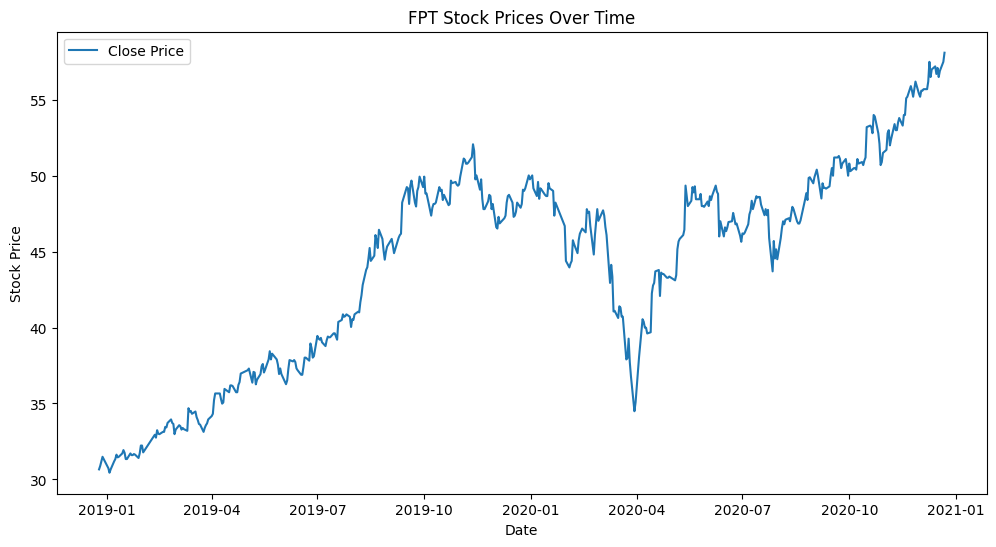

In [615]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt_merged.index, df_fpt_merged['Close'], label='Close Price')
#sns.lineplot(x=df_fpt_merged.index, y="Close", data=df_fpt_merged)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('FPT Stock Prices Over Time')
#plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')) 
plt.legend()
plt.show()

In [616]:
df_fpt = df_fpt_merged

# Model Analysis (RNN, Transfromer, Arima, Holt-Winters)

In [617]:
df_fpt

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25,30.890000,30.890000,30.590,30.66,84960
2018-12-26,31.040000,31.220000,30.890,30.89,333590
2018-12-27,31.410000,31.520000,31.190,31.19,454860
2018-12-28,31.340000,31.490000,31.190,31.49,387170
2018-12-29,31.310000,31.482000,31.092,31.34,0
...,...,...,...,...,...
2020-12-18,56.500000,57.000000,56.500,56.90,1532820
2020-12-19,56.766667,57.266667,56.700,57.10,0
2020-12-20,57.033333,57.533333,56.900,57.30,0


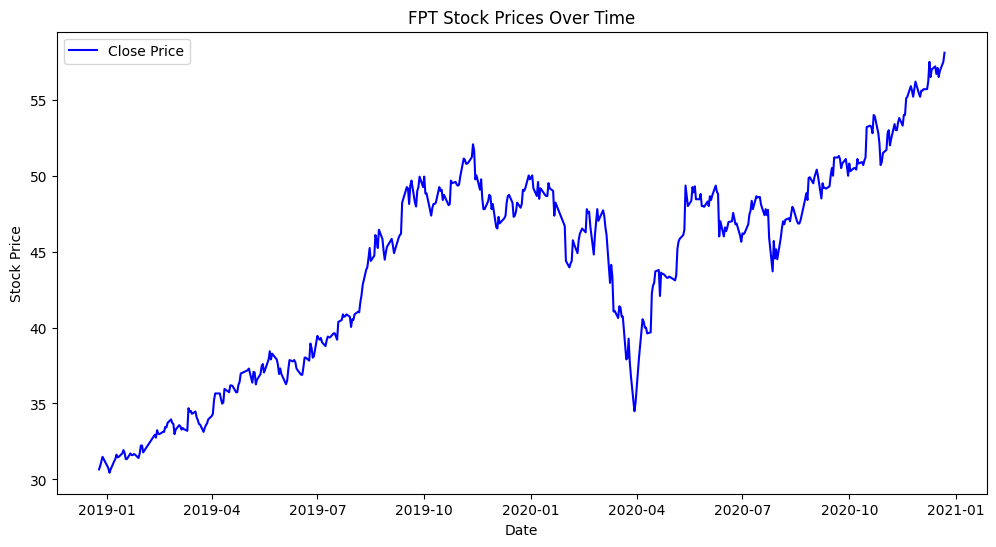

In [618]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index, df_fpt['Close'], label='Close Price', color='blue')
#plt.plot(df_fpt['Date/Time'], df_fpt['Open'], label='Open Price', color='green', linestyle='dashed')
#plt.plot(df_fpt['Date/Time'], df_fpt['High'], label='High Price', color='red', linestyle='dotted')
#plt.plot(df_fpt['Date/Time'], df_fpt['Low'], label='Low Price', color='purple', linestyle='dotted')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('FPT Stock Prices Over Time')
#plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')) 
plt.legend()
plt.show()

In [619]:
df_fpt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2018-12-25 to 2020-12-22
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    729 non-null    float64
 1   High    729 non-null    float64
 2   Low     729 non-null    float64
 3   Close   729 non-null    float64
 4   Volume  729 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 50.3 KB


## Train, test, validation sets split

Normalize data

In [620]:
df_fpt = df_fpt[['Open', 'High', 'Low', 'Close', 'Volume']]

# Normalize the data
scaler = MinMaxScaler()
df_fpt_normalized = scaler.fit_transform(df_fpt)

In [621]:
# Define a function to create the input sequences and labels
def create_sequences(data, seq_length): # seq_length: number of days to look back
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the sequence length
sequence_length = 60 # 60 days

Without validation

In [622]:
# # Create sequences and labels
# sequences, labels = create_sequences(df_fpt_normalized, sequence_length)

# # Use the first 80% of the data for training
# train_size = int(len(sequences) * 0.8)
# X_train, y_train = sequences[:train_size], labels[:train_size]

# # Use the remaining 20% as the test set
# X_test, y_test = sequences[train_size:], labels[train_size:]
# print(X_train.shape)
# print(X_test.shape)

With validation

for more information, look this: https://forecastegy.com/posts/time-series-cross-validation-python/

In [699]:
sequences, labels = create_sequences(df_fpt_normalized, sequence_length)

In [733]:
# This is the normal way to split train, test, validation sets
# Split the data into train, validation, and test sets
train_size = int(len(sequences) * 0.8)
val_size = int(len(sequences) * 0.1)

train_size = train_size - val_size
X_train, y_train = sequences[:train_size], labels[:train_size]
X_val, y_val = sequences[train_size:train_size + val_size], labels[train_size:train_size + val_size]
X_test, y_test = sequences[train_size + val_size:], labels[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (469, 60, 5)
y_train shape: (469, 5)
X_val shape: (66, 60, 5)
y_val shape: (66, 5)
X_test shape: (134, 60, 5)
y_test shape: (134, 5)


In [625]:
# # Use TimeSeriesSplit with Expanding Window Validation
# tscv = TimeSeriesSplit(n_splits=5)  # 

# for train_index, test_index in tscv.split(sequences):
#     X_train, X_test = sequences[train_index], sequences[test_index]
#     y_train, y_test = labels[train_index], labels[test_index]

#     train_size = int(len(X_train) * 0.8)
#     val_size = len(X_train) - train_size
#     X_train, X_val = X_train[:train_size], X_train[train_size:]
#     y_train, y_val = y_train[:train_size], y_train[train_size:]

#     print("\nTrain shape:", X_train.shape, y_train.shape)
#     print("Validation shape:", X_val.shape, y_val.shape)
#     print("Test shape:", X_test.shape, y_test.shape)

# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

In [626]:
print(train_size)
print(val_size)

428
107


In [627]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(428, 60, 5)
(134, 60, 5)
(107, 60, 5)


In [628]:
# df_fake = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# sequences, labels = create_sequences(df_fake, sequence_length)

# # Split the data into train (70%), validation (10%), and test (20%) sets
# train_size = int(len(sequences) * 0.7)
# val_size = int(len(sequences) * 0.1)

# X_train, y_train = sequences[:train_size], labels[:train_size]
# X_val, y_val = sequences[train_size:train_size + val_size], labels[train_size:train_size + val_size]
# X_test, y_test = sequences[train_size + val_size:], labels[train_size + val_size:]
# print(X_train.shape)
# print(X_test.shape)
# print(X_val.shape)

## GRU vs BiLSTM model

In [734]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model_gru = Sequential()
model_gru.add(GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(5))

# Compile the model
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history_gru = model_gru.fit(X_train, y_train, 
                            epochs=300, batch_size=64, 
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss_gru = model_gru.evaluate(X_test, y_test)

Epoch 1/300
8/8 [==============================] - 3s 107ms/step - loss: 0.2111 - val_loss: 0.1335
Epoch 2/300
8/8 [==============================] - 0s 44ms/step - loss: 0.0575 - val_loss: 0.0103
Epoch 3/300
8/8 [==============================] - 0s 45ms/step - loss: 0.0213 - val_loss: 0.0146
Epoch 4/300
8/8 [==============================] - 0s 44ms/step - loss: 0.0213 - val_loss: 0.0093
Epoch 5/300
8/8 [==============================] - 0s 42ms/step - loss: 0.0157 - val_loss: 0.0085
Epoch 6/300
8/8 [==============================] - 0s 44ms/step - loss: 0.0140 - val_loss: 0.0074
Epoch 7/300
8/8 [==============================] - 0s 45ms/step - loss: 0.0135 - val_loss: 0.0057
Epoch 8/300
8/8 [==============================] - 0s 40ms/step - loss: 0.0122 - val_loss: 0.0057
Epoch 9/300
8/8 [==============================] - 0s 51ms/step - loss: 0.0122 - val_loss: 0.0056
Epoch 10/300
8/8 [==============================] - 0s 51ms/step - loss: 0.0111 - val_loss: 0.0058
Epoch 11/300
8/8 [

In [735]:
model_gru.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 64)                13632     
                                                                 
 dropout_124 (Dropout)       (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 5)                 325       
                                                                 
Total params: 13957 (54.52 KB)
Trainable params: 13957 (54.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [736]:
# Build BiLSTM model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(LSTM(50))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(5))

# Compile the model
model_bilstm.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history_bilstm = model_bilstm.fit(X_train, y_train, 
                                  epochs=300, batch_size=64, 
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss_bilstm = model_bilstm.evaluate(X_test, y_test)

Epoch 1/300
8/8 [==============================] - 7s 241ms/step - loss: 0.0828 - val_loss: 0.0294
Epoch 2/300
8/8 [==============================] - 1s 136ms/step - loss: 0.0227 - val_loss: 0.0124
Epoch 3/300
8/8 [==============================] - 1s 130ms/step - loss: 0.0181 - val_loss: 0.0080
Epoch 4/300
8/8 [==============================] - 1s 115ms/step - loss: 0.0144 - val_loss: 0.0065
Epoch 5/300
8/8 [==============================] - 1s 117ms/step - loss: 0.0130 - val_loss: 0.0063
Epoch 6/300
8/8 [==============================] - 1s 109ms/step - loss: 0.0116 - val_loss: 0.0061
Epoch 7/300
8/8 [==============================] - 1s 104ms/step - loss: 0.0110 - val_loss: 0.0059
Epoch 8/300
8/8 [==============================] - 1s 105ms/step - loss: 0.0109 - val_loss: 0.0058
Epoch 9/300
8/8 [==============================] - 1s 115ms/step - loss: 0.0106 - val_loss: 0.0057
Epoch 10/300
8/8 [==============================] - 1s 109ms/step - loss: 0.0109 - val_loss: 0.0058
Epoch 11/

In [737]:
model_bilstm.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirect  (None, 60, 128)           35840     
 ional)                                                          
                                                                 
 dropout_125 (Dropout)       (None, 60, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 50)                35800     
                                                                 
 dropout_126 (Dropout)       (None, 50)                0         
                                                                 
 dense_44 (Dense)            (None, 5)                 255       
                                                                 
Total params: 71895 (280.84 KB)
Trainable params: 71895 (280.84 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

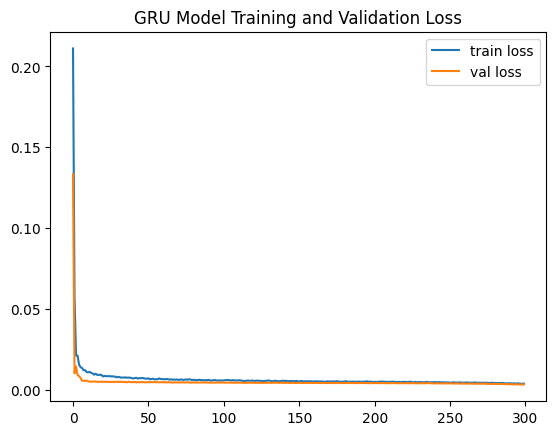

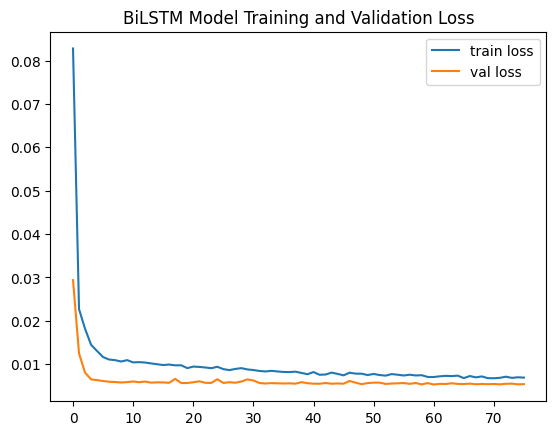

In [738]:
def plot_history(history, title):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot GRU model history
plot_history(history_gru, 'GRU Model Training and Validation Loss')

# Plot BiLSTM model history
plot_history(history_bilstm, 'BiLSTM Model Training and Validation Loss')

The model seems good, however, it seems like overfitting?

In [739]:
# Predictions on the test set
test_predictions_gru = model_gru.predict(X_test)
test_predictions_bilstm = model_bilstm.predict(X_test)

# Inverse transform the normalized data to get the actual values
test_predictions_gru = scaler.inverse_transform(test_predictions_gru)
test_predictions_bilstm = scaler.inverse_transform(test_predictions_bilstm)
y_test_actual = scaler.inverse_transform(y_test)
y_train_actual = scaler.inverse_transform(y_train)
y_val_actual = scaler.inverse_transform(y_val)

5/5 [==============================] - 3s 50ms/step


In [740]:
print(test_predictions_gru.shape)
print(test_predictions_bilstm.shape)
print(y_test_actual.shape)

(134, 5)
(134, 5)
(134, 5)


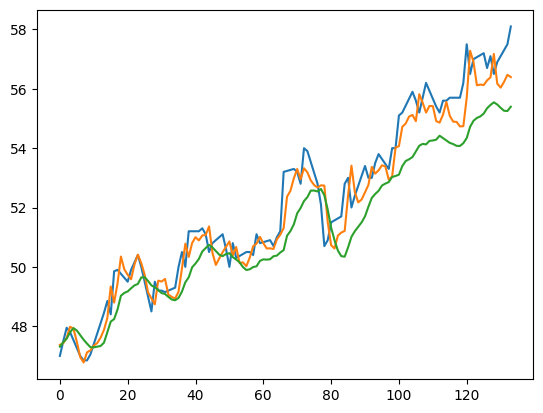

In [741]:
plt.plot(y_test_actual[:,3])
plt.plot(test_predictions_gru[:,3])
plt.plot(test_predictions_bilstm[:,3])

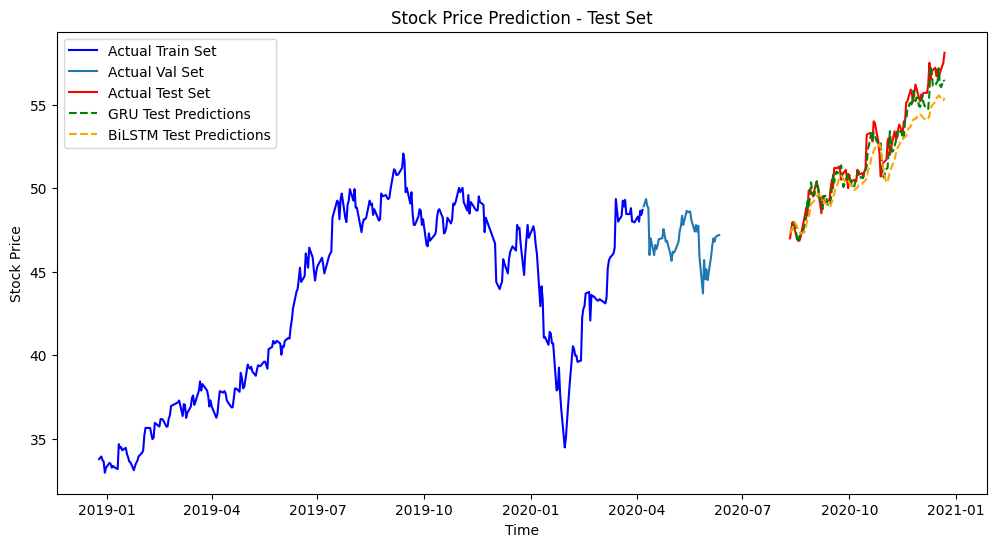

In [742]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index[:train_size], y_train_actual[:, 3], label='Actual Train Set', color='blue')
plt.plot(df_fpt.index[train_size:train_size + val_size], y_val_actual[:, 3], label='Actual Val Set')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', color='green', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', color='orange', linestyle='dashed')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

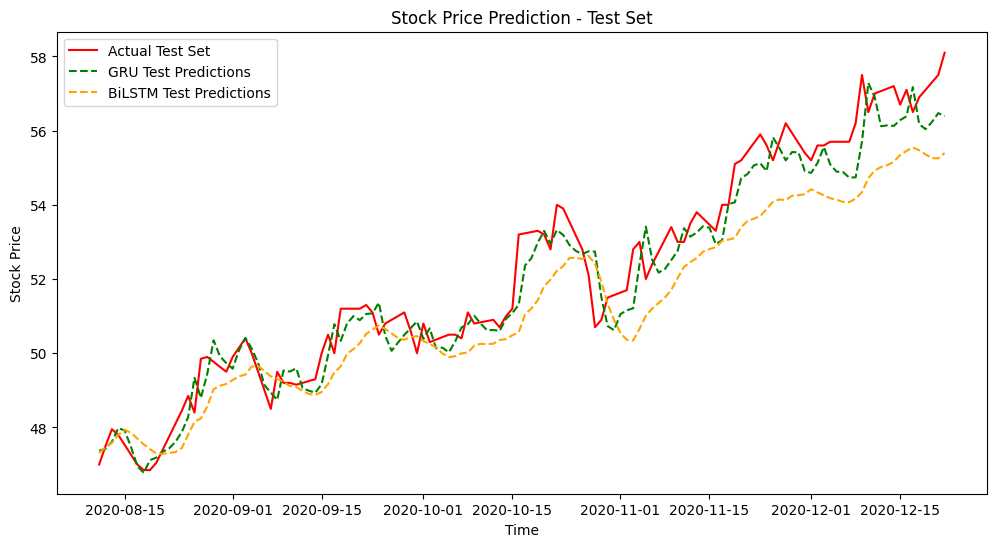

In [743]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', color='green', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', color='orange', linestyle='dashed')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [744]:
# Use the last `sequence_length` data points from the test data to create a new sequence
last_sequence = y_test[-sequence_length:]

# Create a copy of the last sequence for modification
X_future_gru = last_sequence.copy()
X_future_bilstm = last_sequence.copy()

# Number of future data points to predict
num_future_points = 60  # 2 months

# Make predictions for the future data points
for i in range(num_future_points):
    # Predict the next data point
    next_point_gru = model_gru.predict(np.expand_dims(X_future_gru[-sequence_length:], axis=0))
    next_point_bilstm = model_bilstm.predict(np.expand_dims(X_future_bilstm[-sequence_length:], axis=0))

    # Append the predicted points to X_future
    X_future_gru = np.vstack([X_future_gru, next_point_gru[0]])
    X_future_bilstm = np.vstack([X_future_bilstm, next_point_bilstm[0]])

# Inverse transform the normalized data to get the actual values for X_future
X_future_actual_gru = scaler.inverse_transform(X_future_gru)
X_future_actual_bilstm = scaler.inverse_transform(X_future_bilstm)

1/1 [==============================] - 0s 24ms/step


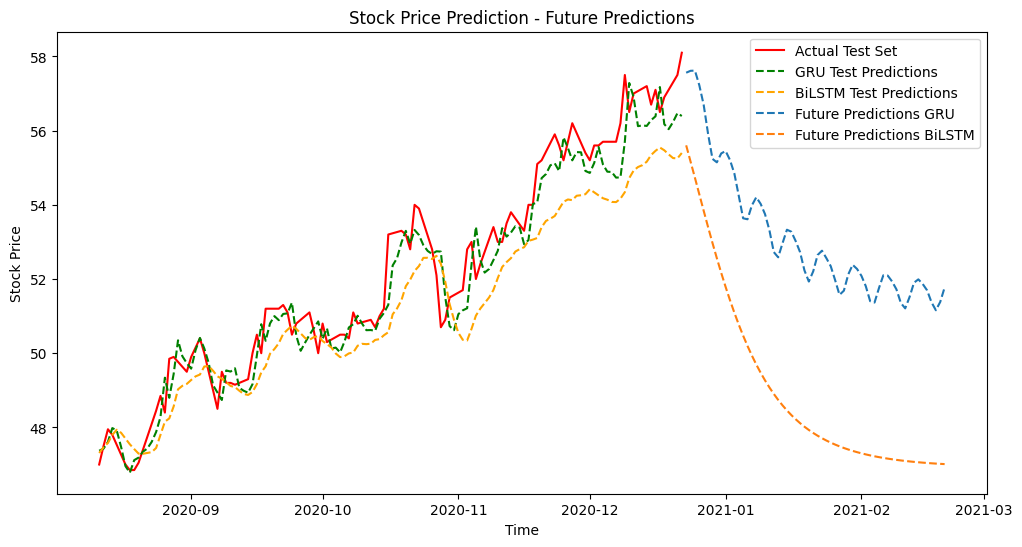

In [745]:
# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(df_fpt.index, df_fpt['Close'], label='Actual Data', color='blue')
#plt.plot(df_fpt.index[train_size + sequence_length:], y_test_actual[:,3], label='Actual Test Set', color='red')
#plt.plot(df_fpt.index[train_size + sequence_length:], test_predictions_gru[:,3], label='GRU Test Predictions', color='green', linestyle='dashed')
#plt.plot(df_fpt.index[train_size + sequence_length:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', color='orange', linestyle='dashed')

plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', color='green', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', color='orange', linestyle='dashed')


#plt.plot(df_fpt.index[-sequence_length:], df_fpt['Close'][-sequence_length:], label='Last Sequence', color='cyan', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_gru[-num_future_points:, 3], label='Future Predictions GRU', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_bilstm[-num_future_points:, 3], label='Future Predictions BiLSTM', linestyle='dashed')

plt.title('Stock Price Prediction - Future Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


True, the models have bad predictions in the future

## Transfomer

Read this for more information: https://arxiv.org/abs/1706.03762

In [746]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [747]:
def build_transformer_model(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0):
    n_timesteps, n_features, n_outputs = sequence_length, 5, 5  
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs

    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)

    outputs = Dense(n_outputs, activation='linear')(x)  
    return tf.keras.Model(inputs, outputs)


In [748]:
# Define hyperparameters
head_size = 128
num_heads = 4
ff_dim = 2
num_trans_blocks = 4
mlp_units = [256]
dropout = 0.10
mlp_dropout = 0.10

# Build and compile the model
transformer_model = build_transformer_model(
    head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout, mlp_dropout
)

transformer_model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'],
)

early_stopping2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = transformer_model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=300,
    #validation_split=0.2,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping2],
    verbose=1
)

Epoch 1/300
8/8 [==============================] - 21s 1s/step - loss: 0.1119 - mae: 0.2593 - mape: 9068629.0000 - val_loss: 0.0523 - val_mae: 0.2085 - val_mape: 18942420.0000
Epoch 2/300
8/8 [==============================] - 11s 1s/step - loss: 0.0407 - mae: 0.1572 - mape: 11738314.0000 - val_loss: 0.0092 - val_mae: 0.0711 - val_mape: 9941565.0000
Epoch 3/300
8/8 [==============================] - 7s 823ms/step - loss: 0.0283 - mae: 0.1293 - mape: 7839321.0000 - val_loss: 0.0157 - val_mae: 0.1036 - val_mape: 7235196.0000
Epoch 4/300
8/8 [==============================] - 10s 1s/step - loss: 0.0236 - mae: 0.1218 - mape: 8621664.0000 - val_loss: 0.0135 - val_mae: 0.0933 - val_mape: 10982704.0000
Epoch 5/300
8/8 [==============================] - 10s 1s/step - loss: 0.0193 - mae: 0.1072 - mape: 9750471.0000 - val_loss: 0.0133 - val_mae: 0.0911 - val_mape: 11931107.0000
Epoch 6/300
8/8 [==============================] - 10s 1s/step - loss: 0.0168 - mae: 0.1000 - mape: 9951213.0000 - val_

In [749]:
transformer_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 60, 5)]              0         []                            
                                                                                                  
 layer_normalization_80 (La  (None, 60, 5)                10        ['input_11[0][0]']            
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_40 (M  (None, 60, 5)                11781     ['layer_normalization_80[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_8

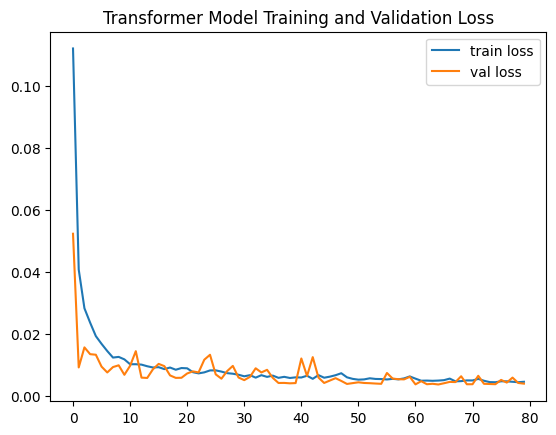

In [750]:
def plot_history_trasnformer(history, title):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_history_trasnformer(history, 'Transformer Model Training and Validation Loss')

In [751]:
# Make predictions on the test set
test_predictions_transformer = transformer_model.predict(X_test)
print(test_predictions_transformer.shape)
# Inverse transform the predictions and labels to the original scale
test_predictions_transformer = scaler.inverse_transform(test_predictions_transformer)


5/5 [==============================] - 1s 146ms/step
(134, 5)


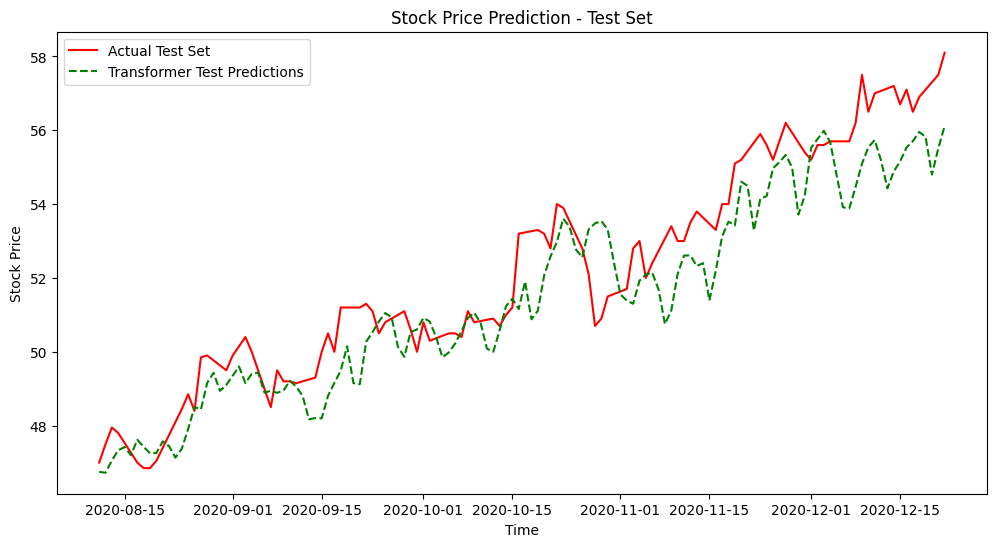

In [755]:
plt.figure(figsize=(12, 6))
#plt.plot(df_fpt.index[:train_size], y_train_actual[:, 3], label='Actual Train Set', color='blue')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', color='green', linestyle='dashed')
plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


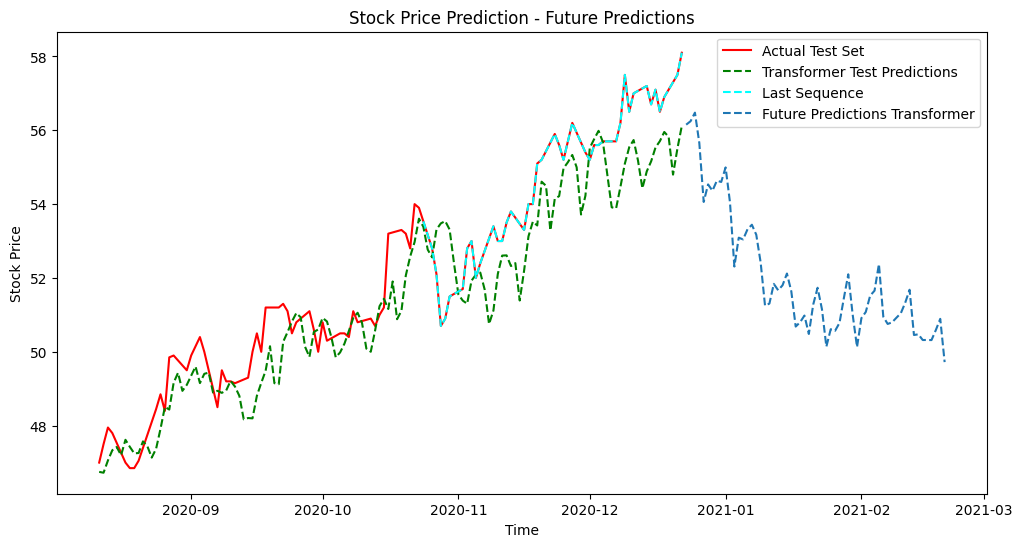

In [764]:
# Use the last `sequence_length` data points from the original data to create a new sequence
last_sequence = df_fpt_normalized[-sequence_length:]

# Create a copy of the last sequence for modification
X_future_transformer = last_sequence.copy()

# Number of future data points to predict
num_future_points = 60  # 2 months

# Make predictions for the future data points
for i in range(num_future_points):
    # Predict the next data point
    next_point_transformer = transformer_model.predict(np.expand_dims(X_future_transformer[-sequence_length:], axis=0))
   
    # Append the predicted points to X_future
    X_future_transformer = np.vstack([X_future_transformer, next_point_transformer[0]])
    
# Inverse transform the normalized data to get the actual values for X_future
X_future_actual_transformer = scaler.inverse_transform(X_future_transformer)

# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(df_fpt.index, df_fpt['Close'], label='Actual Data', color='blue')
#plt.plot(df_fpt.index[train_size + sequence_length:], y_test_actual[:,3], label='Actual Test Set', color='red')

plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', color='green', linestyle='dashed')


plt.plot(df_fpt.index[-sequence_length:], df_fpt['Close'][-sequence_length:], label='Last Sequence', color='cyan', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_transformer[-num_future_points:, 3], label='Future Predictions Transformer', linestyle='dashed')

plt.title('Stock Price Prediction - Future Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


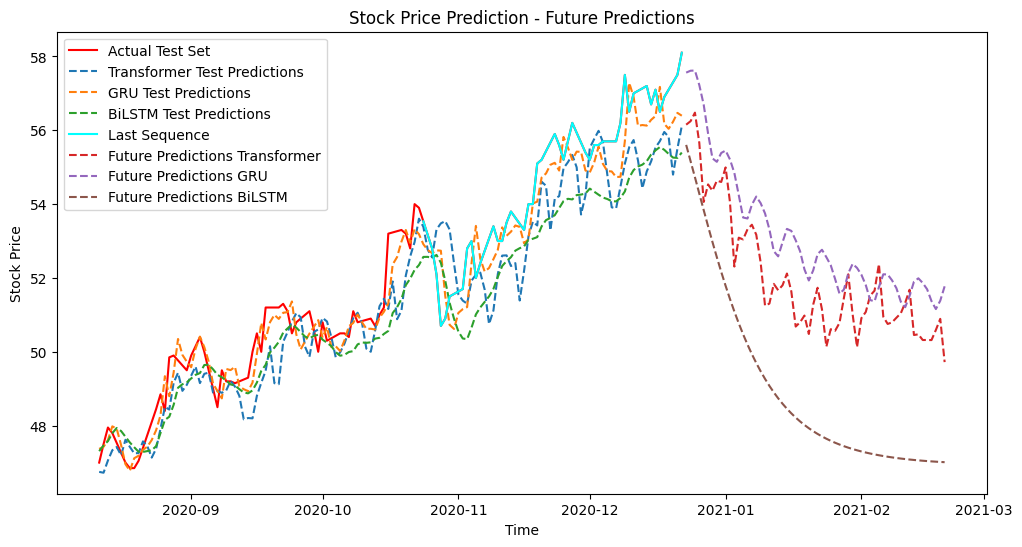

In [765]:
plt.figure(figsize=(12, 6))
#plt.plot(df_fpt.index, df_fpt['Close'], label='Actual Data', color='blue')

plt.plot(df_fpt.index[train_size + sequence_length + val_size:], y_test_actual[:,3], label='Actual Test Set', color='red')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', linestyle='dashed')


plt.plot(df_fpt.index[-sequence_length:], df_fpt['Close'][-sequence_length:], label='Last Sequence', color='cyan')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_transformer[-num_future_points:, 3], label='Future Predictions Transformer', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_gru[-num_future_points:, 3], label='Future Predictions GRU', linestyle='dashed')
plt.plot(pd.date_range(start=df_fpt.index[-1], periods=num_future_points + 1, freq='D')[1:], X_future_actual_bilstm[-num_future_points:, 3], label='Future Predictions BiLSTM', linestyle='dashed')


plt.title('Stock Price Prediction - Future Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

<h3>Overall, well, we can see transformer model is better than others when predicting unseen data (future data). BiLSTM and GRU are overfitting. Here, I think that my work was not completely correct because of limited time, I will do research and figure out a better solution for this.

## Arima, Holt-Winters models

In [768]:
train_set = df_fpt['Close'][: train_size + val_size]
test_set = df_fpt['Close'][train_size + val_size :]

(194,)


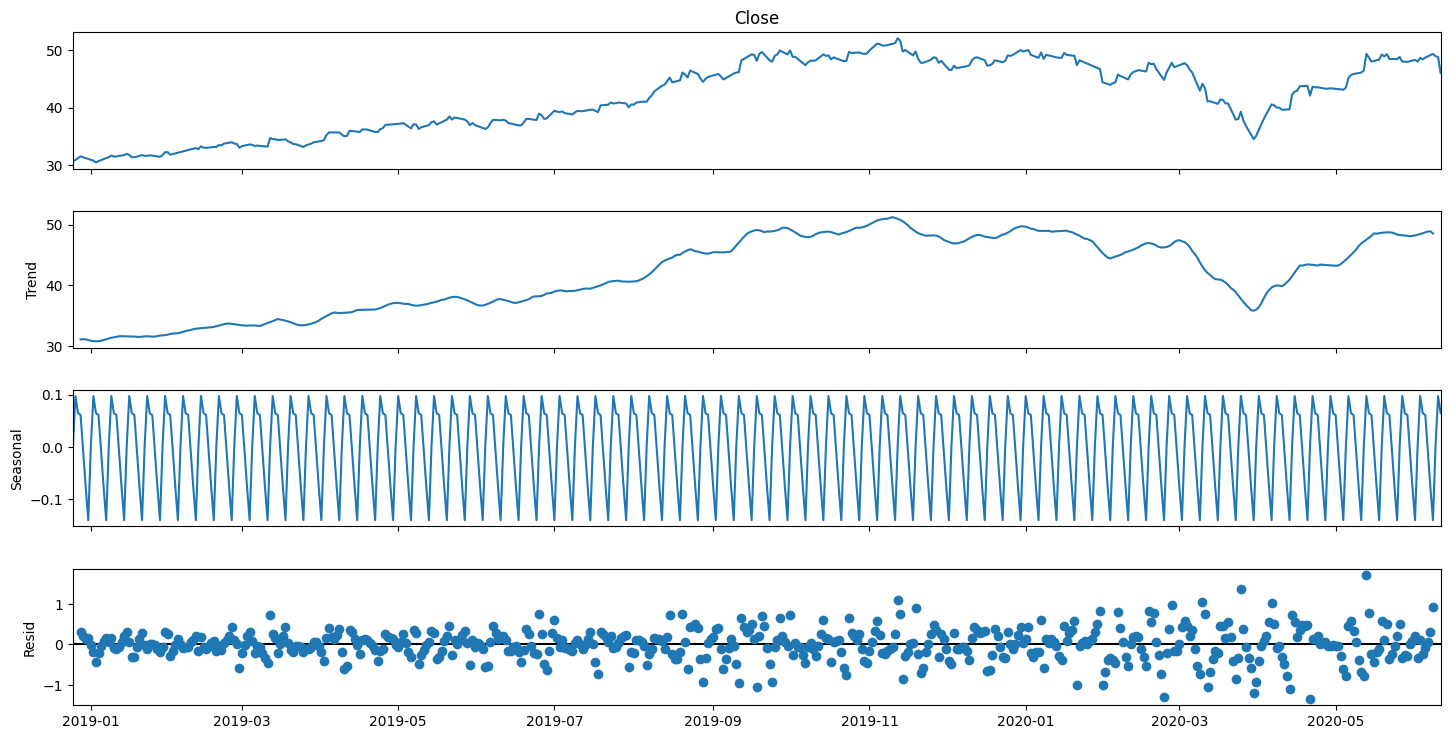

In [769]:
# Decompose the time series using an additive model
str_results = seasonal_decompose(train_set, period=7) # 7 days
fig = str_results.plot()
fig.set_size_inches((16, 8))
print(test_set.shape)

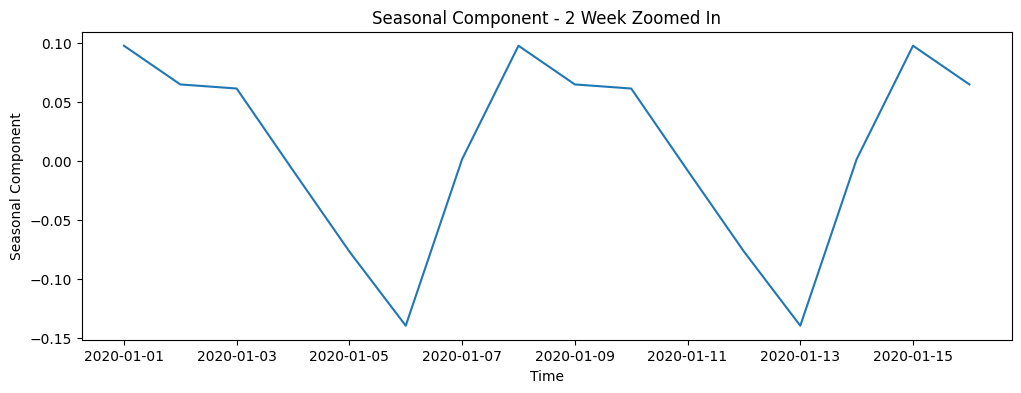

In [770]:
plt.figure(figsize=(12, 4))
plt.plot(str_results.seasonal["2020-01-01":"2020-01-16"])
plt.title('Seasonal Component - 2 Week Zoomed In')
plt.xlabel('Time')
plt.ylabel('Seasonal Component')
plt.show()

In [771]:
trend = str_results.trend
#remove null values
trend = trend.dropna()
print(trend.isna().sum())

0


In [772]:
# ARIMA Model
def train_arima_model(train_data):
    stepwise_model = auto_arima(train_data, start_p=1, start_q=1,
                            max_p=6, max_q=6, m=7, seasonal=True,
                            d=None, D=None, trace=True,
                            error_action='ignore',
                            suppress_warnings=True, stepwise=True)
    return stepwise_model

# Holt-Winters Model
def train_holt_winters_model(train_data):
    model = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=7)
    fitted_model = model.fit()
    return fitted_model

In [773]:
arima_m = train_arima_model(trend) # 3 here is the index of the Close price

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-141.773, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1071.880, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-557.229, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-130.969, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-932.295, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=-1113.238, Time=0.89 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-141.927, Time=0.34 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=-1116.037, Time=1.39 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=-1073.264, Time=0.36 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=-1116.293, T

In [774]:
# Forecast using ARIMA model
prediction_arima, arima_conf_int = arima_m.predict(n_periods=len(test_set), return_conf_int=True)
print(prediction_arima.tail(), test_set.shape)

2020-12-15    51.584691
2020-12-16    51.613666
2020-12-17    51.642641
2020-12-18    51.671616
2020-12-19    51.700591
Freq: D, dtype: float64 (194,)


In [775]:
# add seasonality and residual to the prediction but retain the shape of the test set
for i in range(len(prediction_arima) -3):
    # if str_results.resid is null, then prediction[i] = prediction[i] + str_results.seasonal[-len(prediction) + i]
    if str_results.resid[-len(prediction_arima) + i] is None:
        prediction_arima[i] = prediction_arima[i] + str_results.seasonal[-len(prediction_arima) + i] + 0
    else:
        prediction_arima[i] = prediction_arima[i] + str_results.seasonal[-len(prediction_arima) + i] + str_results.resid[-len(prediction_arima) + i]
print(prediction_arima.tail())

2020-12-15    51.825168
2020-12-16    52.413666
2020-12-17    51.642641
2020-12-18    51.671616
2020-12-19    51.700591
Freq: D, dtype: float64


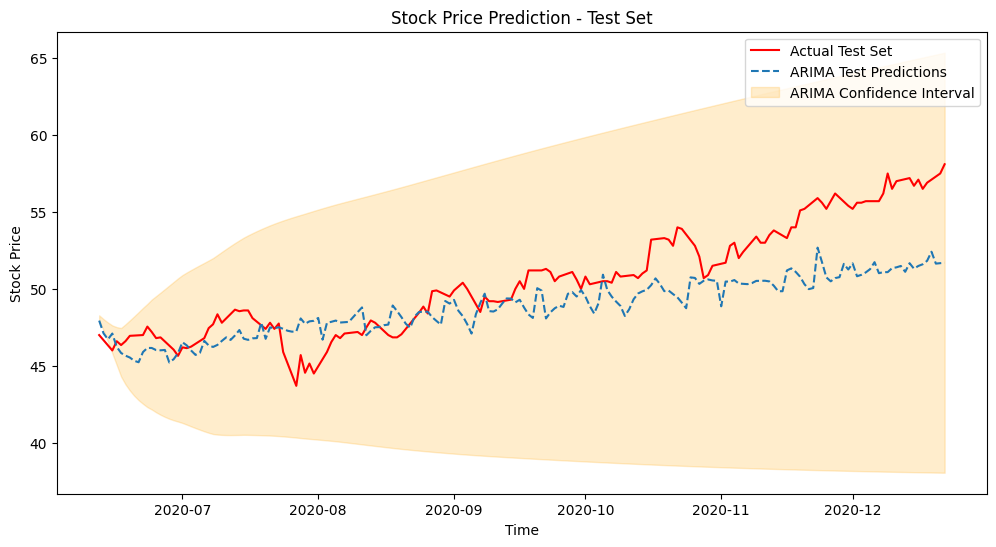

In [776]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index[train_size  + val_size:], test_set, label='Actual Test Set', color='red')
#plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', linestyle='dashed')
#plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', linestyle='dashed')
#plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + val_size:], prediction_arima, label='ARIMA Test Predictions', linestyle='dashed')
plt.fill_between(df_fpt.index[train_size + val_size:], arima_conf_int[:, 0], arima_conf_int[:, 1], color='orange', alpha=0.2, label='ARIMA Confidence Interval')

plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [777]:
holt_winters_model = train_holt_winters_model(train_set)

In [778]:
# Forecast using ARIMA model
prediction_hw = holt_winters_model.forecast(steps=len(test_set))
print(prediction_hw.tail(), test_set.shape)

# add seasonality and residual to the prediction but retain the shape of the test set
for i in range(len(prediction_hw) -3):
    # if str_results.resid is null, then prediction[i] = prediction[i] + str_results.seasonal[-len(prediction) + i]
    if str_results.resid[-len(prediction_hw) + i] is None:
        prediction_hw[i] = prediction_hw[i] + str_results.seasonal[-len(prediction_hw) + i] + 0
    else:
        prediction_hw[i] = prediction_hw[i] + str_results.seasonal[-len(prediction_hw) + i] + str_results.resid[-len(prediction_hw) + i]
print(prediction_hw.tail())

2020-12-18    51.446639
2020-12-19    51.411709
2020-12-20    51.376793
2020-12-21    51.341856
2020-12-22    51.520305
Freq: D, dtype: float64 (194,)
2020-12-18    51.687116
2020-12-19    52.211709
2020-12-20    51.376793
2020-12-21    51.341856
2020-12-22    51.520305
Freq: D, dtype: float64


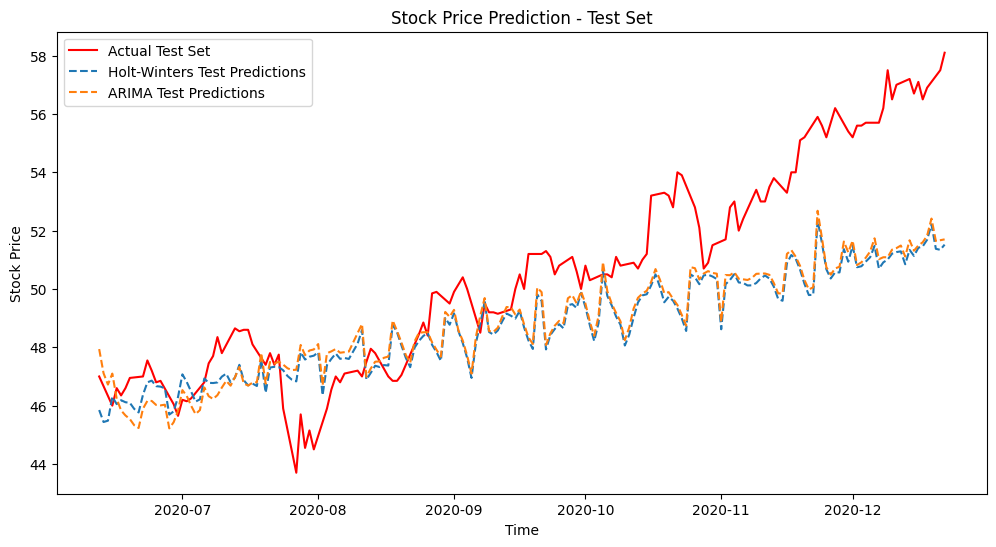

In [779]:
plt.figure(figsize=(12, 6))
plt.plot(df_fpt.index[train_size + val_size:], test_set, label='Actual Test Set', color='red')
#plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_transformer[:,3], label='Transformer Test Predictions', linestyle='dashed')
#plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_gru[:,3], label='GRU Test Predictions', linestyle='dashed')
#plt.plot(df_fpt.index[train_size + sequence_length + val_size:], test_predictions_bilstm[:,3], label='BiLSTM Test Predictions', linestyle='dashed')
plt.plot(df_fpt.index[train_size + val_size:], prediction_hw, label='Holt-Winters Test Predictions', linestyle='dashed')

plt.plot(df_fpt.index[train_size + val_size:], prediction_arima, label='ARIMA Test Predictions', linestyle='dashed')

plt.title('Stock Price Prediction - Test Set')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

<h3>In comparing the Arima model to Holt-Winters, it becomes evident that the Arima model outperforms the latter. The predictive capabilities of Arima are notably superior. However, it's crucial to acknowledge a significant drawback—after forecasting future values, there is a noticeable repetition in both the seasonal and residual components. This recurrence adversely impacts the accuracy of predictions, resulting in suboptimal outcomes. Addressing and mitigating this repetition issue is essential for maximizing the effectiveness of the Arima model in real-world applications.</h3>